In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy as sc
import scipy
from scipy import io

import theano
import theano.tensor as T
import lasagne
from lasagne.layers import *
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
X = scipy.io.loadmat('../dataX.mat')['arr']
Y = scipy.io.loadmat('../dataY.mat')['arr']
# some daily information (5 weeks)
X = X[:-8, :-35]
Y = Y[8:, :-5]
print(X.shape, Y.shape)

(1081, 168) (1081, 24)


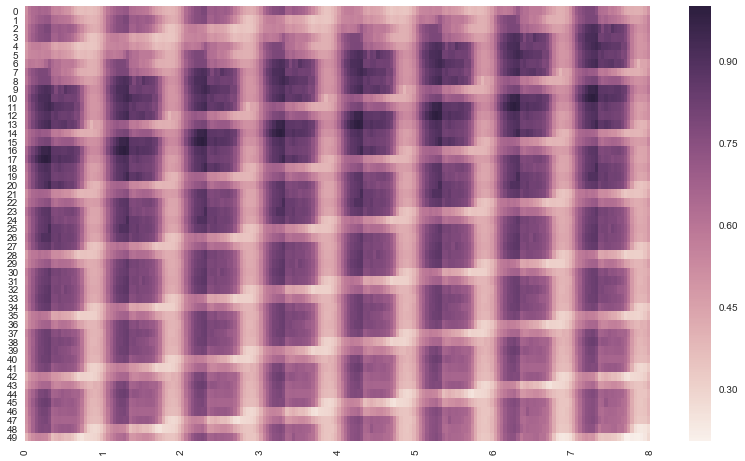

In [4]:
plt.figure(figsize=(14, 8))
mat = np.hstack([X[:50, :], Y[:50, :]])
sns.heatmap(mat)
start, end, stepsize = 0, mat.shape[1] + 1, 24
plt.xticks(np.arange(start, end, stepsize))
plt.show()

In [32]:
input_X = T.matrix()

def build_nn(n_features, n_hidden=20):
    net = {}
    net['l_input'] = InputLayer(shape=(None, n_features), input_var=input_X)
    net['l_hidden'] = DenseLayer(net['l_input'], num_units=n_hidden, nonlinearity=lasagne.nonlinearities.sigmoid)
    net['l_out'] = DenseLayer(net['l_hidden'], num_units=n_features)
    return net

In [33]:
def iterate_minibatches(inputs, batchsize, shuffle=False):
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt]

In [34]:
n_epochs = 10
batchsize = 32
n_hiddens = [50, 20]
Z = X.copy()
for ae in range(len(n_hiddens)):
    net = build_nn(Z.shape[1], n_hiddens[ae])
    weights = get_all_params(net['l_out'], trainable=True)
    recovered_X = get_output(net['l_out'])
    z = get_output(net['l_hidden'])
    loss = T.mean(lasagne.objectives.squared_error(input_X, recovered_X))
    updates = lasagne.updates.adam(loss, weights, learning_rate=0.005)
    train = theano.function([input_X], loss, updates=updates)
    representation = theano.function([input_X], z)
    
    loss_array = []
    for epoch in range(n_epochs):
        k = 0
        loss_array.append(0)
        for batch in iterate_minibatches(Z, batchsize):
            loss_array[-1] += train(batch)
            k += 1
        loss_array[-1] /= k
        print("Autoencoder: {:d}, epoch: {:d}, loss: {:.3f}".format(ae+1, 
                                                                   epoch+1, loss_array[-1]))
    Z = representation(Z)

Autoencoder: 1, epoch: 1, loss: 0.119
Autoencoder: 1, epoch: 2, loss: 0.094
Autoencoder: 1, epoch: 3, loss: 0.086
Autoencoder: 1, epoch: 4, loss: 0.083
Autoencoder: 1, epoch: 5, loss: 0.081
Autoencoder: 1, epoch: 6, loss: 0.079
Autoencoder: 1, epoch: 7, loss: 0.078
Autoencoder: 1, epoch: 8, loss: 0.078
Autoencoder: 1, epoch: 9, loss: 0.082
Autoencoder: 1, epoch: 10, loss: 0.076
Autoencoder: 2, epoch: 1, loss: 0.116
Autoencoder: 2, epoch: 2, loss: 0.095
Autoencoder: 2, epoch: 3, loss: 0.094
Autoencoder: 2, epoch: 4, loss: 0.093
Autoencoder: 2, epoch: 5, loss: 0.093
Autoencoder: 2, epoch: 6, loss: 0.093
Autoencoder: 2, epoch: 7, loss: 0.092
Autoencoder: 2, epoch: 8, loss: 0.092
Autoencoder: 2, epoch: 9, loss: 0.091
Autoencoder: 2, epoch: 10, loss: 0.082


In [35]:
Z.shape

(1081, 20)

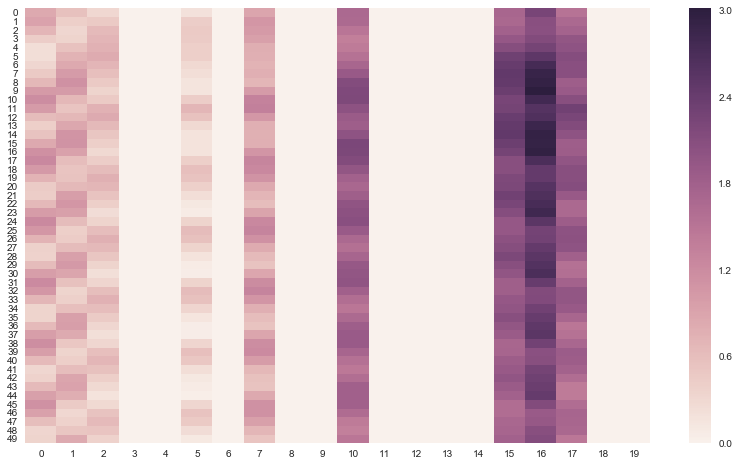

In [12]:
plt.figure(figsize=(14, 8))
sns.heatmap(Z[:50, :])

plt.show()

In [21]:
Z_train, Z_test = Z[:700, :], Z[700:, :]
Y_train, Y_test = Y[:700, :], Y[700:, :]

In [24]:
n_array = np.arange(2, 20)

best_mse = np.inf

for n in n_array:
    pls = PLSRegression(n_components=n, scale=False)
    pls.fit(Z_train, Y_train)
    Y_pred = pls.predict(Z_test)
    mse = mean_squared_error(Y_test, Y_pred)
    if mse < best_mse:
        best_n = n
        best_mse = mse
best_n, best_mse

/Users/m/anaconda/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:319: UserWarning: X scores are null at iteration 9
  warnings.warn('X scores are null at iteration %s' % k)


(8, 0.0035352481923044709)

In [28]:
pls = PLSRegression(n_components=best_n, scale=False)
pls.fit(
    Z_train, Y_train)
Y_pred = pls.predict(Z_test)
W = pls.x_weights_

In [43]:
def mape(Y_test, Y_pred, vector=False):
    n = Y_test.shape[0]
    m = Y_test.shape[1]
    if vector==False:
        res = np.sum(np.divide(np.abs(Y_test - Y_pred), Y_test)) * 100 / n / m
    else:
        res = np.sum(np.divide(np.abs(Y_test - Y_pred), Y_test), 0) * 100 / n  
    return res

In [44]:
print(mean_squared_error(Y_test, Y_pred))
print(mean_absolute_error(Y_test, Y_pred))
print(mape(Y_test, Y_pred))

0.0035352481923
0.0437291134421
14.6815806194
